In [244]:
%matplotlib inline

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [245]:
image_path = "urban grids/maze2.png"

In [246]:
BLACK = [0, 0, 0]
WHITE = [255, 255, 255]
BLUE = [0, 0, 255]
GREEN = [0, 255, 0]
YELLOW = [255, 255, 0]

FREE_CELL = 0
OBSTACLE = 1
START = 2
GOAL = 3

In [247]:
base_reward = 0.1
# base_reward = -15
# antenna_reward = 0.00000003
antenna_reward = 0.3

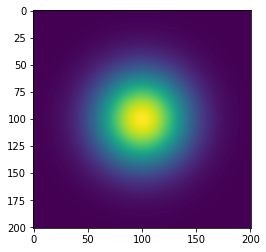

In [248]:
radius = 100
sigma = 30
mu = 0
from scipy.stats import multivariate_normal

gauss2d = multivariate_normal([mu, mu], [[sigma ** 2, 0], [0, sigma ** 2]])
X, Y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
antenna_distribution = gauss2d.pdf(pos)
antenna_distribution -= antenna_distribution.min()
antenna_distribution *= antenna_reward / antenna_distribution.max()
# antenna_distribution = np.where(antenna_distribution < antenna_distribution.mean(), 0, antenna_reward)
plt.imshow(antenna_distribution)

<ipython-input-249-974d9613519b>:61: RuntimeWarning: divide by zero encountered in log
  c = np.log(c)


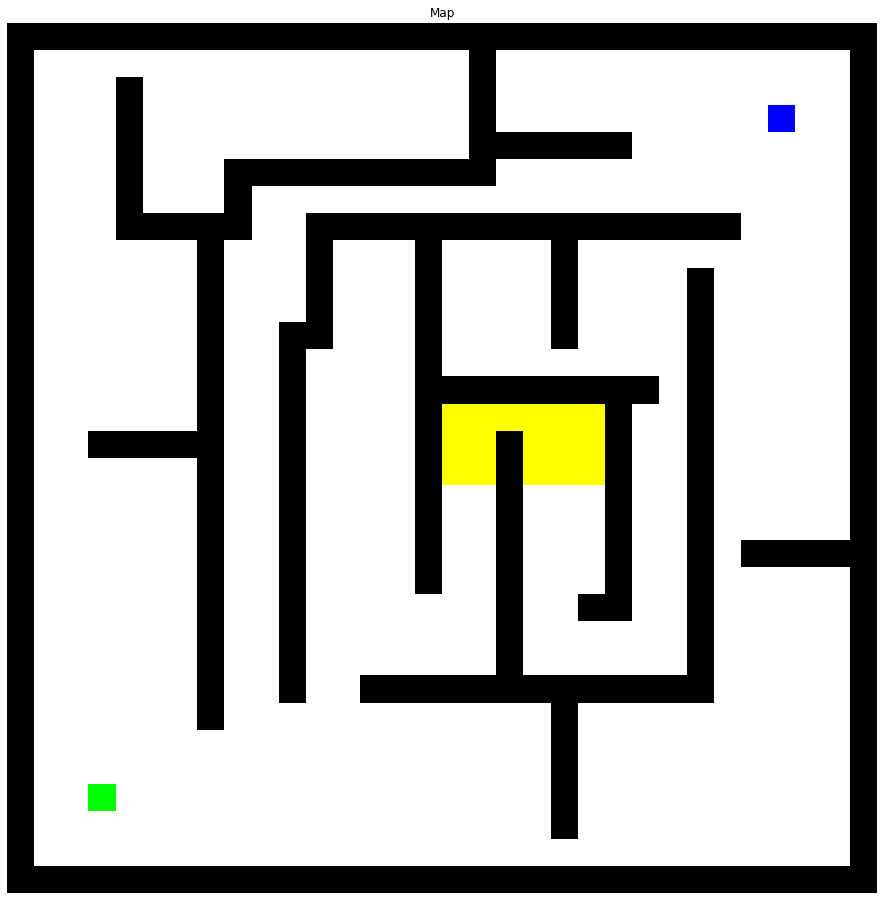

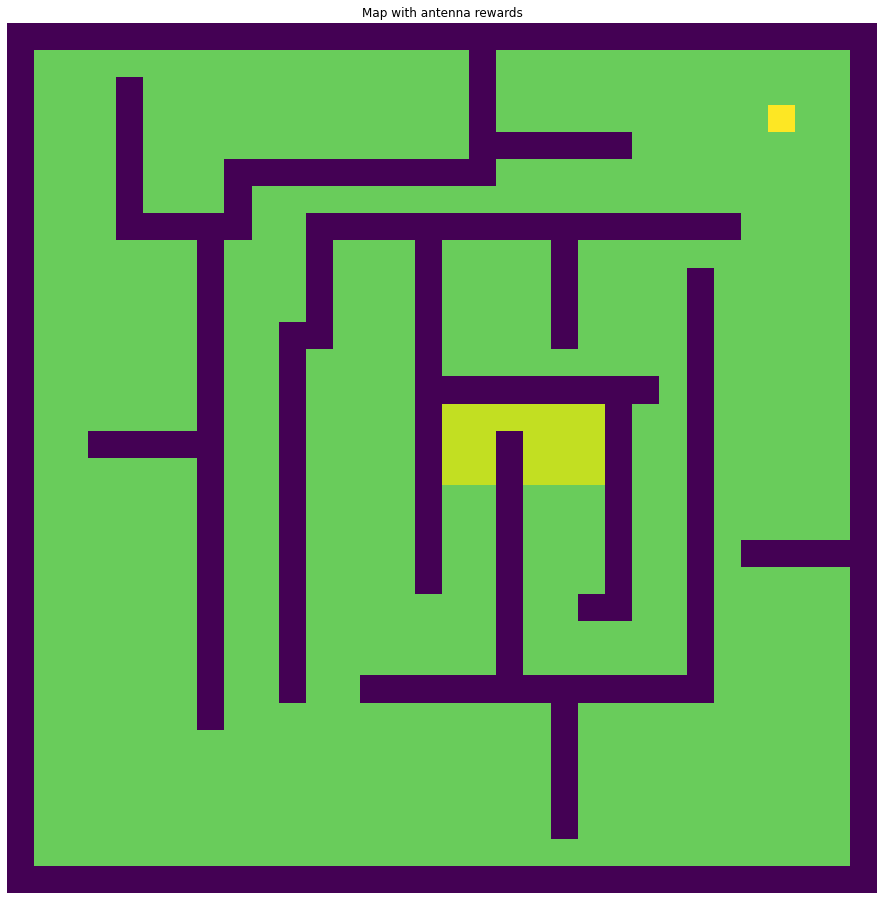

In [249]:
image = Image.open(image_path)
size = image.size
data = np.asarray(image)
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map')
ax.imshow(data)
cell_types = np.zeros(size, dtype=int)
c = np.zeros(size, dtype=np.float32)
antenna_indexes = []
for x in range(size[0]):
    for y in range(size[1]):
        cell = data[x, y, :]
        if np.array_equal(cell, BLACK):
            cell_types[x, y] = OBSTACLE
            c[x, y] = 0
        elif np.array_equal(cell, WHITE):
            cell_types[x, y] = FREE_CELL
            c[x, y] = base_reward
        elif np.array_equal(cell, GREEN):
            cell_types[x, y] = START
            c[x, y] = base_reward
        elif np.array_equal(cell, BLUE):
            cell_types[x, y] = GOAL
            c[x, y] = 1.0
        elif np.array_equal(cell, YELLOW):
            cell_types[x, y] = OBSTACLE
            antenna_indexes.append((x, y))
            # c[x,y] = base_reward+antenna_reward
obstacle_map = np.where(cell_types == OBSTACLE, 0, 1).astype(np.float32)

start = np.copy(cell_types)
start = np.where(start != START, 0, start)
start = np.where(start == START, 1, start).astype(np.float32)

goal = np.copy(cell_types)
goal = np.where(goal != GOAL, 0, goal)
goal = np.where(goal == GOAL, 1, goal).astype(np.float32)

if len(antenna_indexes) > 0:
    map = np.zeros(c.shape)
    for index in antenna_indexes:
        x = index[0]
        y = index[1]
        x_min_radius = x if x <= radius else radius
        x_max_radius = radius + 1 if x + radius + 1 < size[0] else size[0] - x
        y_min_radius = y if y <= radius else radius
        y_max_radius = radius + 1 if y + radius + 1 < size[1] else size[1] - y
        distribution = antenna_distribution[radius - x_min_radius:radius + x_max_radius,
                       radius - y_min_radius:radius + y_max_radius]
        mask = obstacle_map[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius]
        c[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius] += mask * distribution
        map[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius] += mask * distribution
    # map = np.where(map > 0, -1, 0)
    # c = np.where(map == -1, -10, c)
    # c = np.where(c==0,-100, c)
    c /= c.max()
    #c[start == 1] = 1
    c[goal == 1] = 1

c = np.log(c)
c = np.where(c == - np.inf, -100, c)
# c[goal == 1] = 0
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with antenna rewards')
ax.imshow(np.where(c==-100, -10,c))

In [250]:
states = np.zeros(size)
cell_types = cell_types.astype(int)
# states
it = np.nditer(states, flags=['multi_index'])
n_states = 0
while not it.finished:
    x, y = it.multi_index
    if cell_types[x, y] != GOAL:
        n_states += 1
        states[x, y] = n_states
    else:
        states[x, y] = 0

    it.iternext()
n_states += 1
V = np.zeros(n_states)


# actions
def is_out_of_bounds(new_index):
    return np.any(np.array(new_index) > (np.array(states.shape) - 1)) or np.any(np.array(new_index) < 0)


moves = [
    lambda x, y: (np.clip(x - 1, 0, size[0] - 1), y),  # Up
    lambda x, y: (x, y) if is_out_of_bounds((x - 1, y + 1)) else (x - 1, y + 1),  # Up-Right
    lambda x, y: (x, np.clip(y + 1, 0, size[0] - 1)),  # Right
    lambda x, y: (x, y) if is_out_of_bounds((x + 1, y + 1)) else (x + 1, y + 1),  # Down-Right
    lambda x, y: (np.clip(x + 1, 0, size[0] - 1), y),  # Down
    lambda x, y: (x, y) if is_out_of_bounds((x + 1, y - 1)) else (x + 1, y - 1),  # Down-Left
    lambda x, y: (x, np.clip(y - 1, 0, size[0] - 1)),  # Left
    lambda x, y: (x, y) if is_out_of_bounds((x - 1, y - 1)) else (x - 1, y - 1),  # Up-Left
    lambda x, y: (x, y),  # Still
]
n_actions = len(moves)
current_step = 0
policy = np.zeros(n_states)
gamma = 0.9790005
theta = 0.000001

In [251]:
def move(x, y, n_action):
    if cell_types[x, y] == GOAL:
        next_state = 0
        reward = 0
    elif cell_types[x, y] == OBSTACLE:
        next_state = states[x, y]
        reward = 0
    else:
        new_index = moves[n_action](x, y)
        reward = c[new_index]
        next_state = states[new_index] if reward >= -90 else states[x, y]
    return int(next_state), reward

In [252]:
finished = False


def generator():
    i = 1
    while not finished:
        yield i
        i += 1

In [253]:
rewards = np.zeros((n_actions, size[0], size[1]))
next_states = np.zeros((n_actions, size[0], size[1]), dtype=np.intp)
iter = np.nditer(states, flags=['multi_index'])
while not iter.finished:
    x, y = iter.multi_index
    if cell_types[x, y] == OBSTACLE:
        iter.iternext()
        continue
    for a in range(n_actions):
        next_state, reward = move(x, y, a)
        rewards[a, x, y] = reward
        next_states[a, x, y] = next_state
    iter.iternext()

In [254]:
def values_to_V(val):
    vv = np.zeros(n_states)
    it = np.nditer(states, flags=['multi_index'])
    while not it.finished:
        x, y = it.multi_index
        vv[int(states[x, y])] = val[x, y]
        it.iternext()
    return vv

In [255]:
finished = False
p_bar = tqdm(generator(), desc="t")
values = np.zeros(obstacle_map.shape)
policy = np.zeros(obstacle_map.shape)

for t in p_bar:
    delta = 0.0
    v = np.copy(values)
    actions = rewards + gamma * V[next_states]
    values = np.max(actions, 0)
    V = values_to_V(values)
    delta = max(delta, np.max(np.abs(v - values)))
    policy = np.argmax(actions, 0)

    p_bar.set_description(f"{delta}")
    if delta < theta:
        finished = True

t: 0it [00:00, ?it/s]

In [256]:
# finished = False
# p_bar = tqdm(generator(), desc="t")
# for t in p_bar:
#     delta = 0.0
#     it = np.nditer(states, flags=['multi_index'])
#     while not it.finished:
#         x, y = it.multi_index
#         if cell_types[x, y] == OBSTACLE:
#             it.iternext()
#             continue
#         s = int(states[x, y])
#         v = V[s]
#         actions = rewards[:, x, y] + gamma * V[next_states[:, x, y]]
#         V[s] = actions.max()
#         delta = max(delta, abs(v - V[s]))
#         best_action = np.argmax(actions)
#         policy[s] = best_action
#         it.iternext()
#     if delta < theta:
#         finished = True

In [257]:
# arrws = ['↑', '↗', '→', '↘', '↓', '↙', '←', '↖', '']
#
# arrows = [["" for _ in range(size[0])] for _ in range(size[0])]
# it = np.nditer(states, flags=['multi_index'])
# while not it.finished:
#     x, y = it.multi_index
#     s = states[x, y]
#     best_action = policy[x, y]
#     arrows[x][y] = arrws[best_action] if cell_types[x, y] in [FREE_CELL, START] else 'o' if cell_types[
#                                                                                                 x, y] == OBSTACLE else "G"
#     it.iternext()

# from PIL import Image, ImageDraw, ImageFont
#
# pixel_size = 50
# font_size = 36
# font_color = (0, 0, 0)
# img = Image.new('RGB', (pixel_size * size[0], pixel_size * size[1]), color=(255, 255, 255))
# unicode_font = ImageFont.truetype("DejaVuSans.ttf", font_size)
# canvas = ImageDraw.Draw(img)
# for x, row in enumerate(arrows):
#     for y, value in enumerate(row):
#         if value == "o":
#             canvas.rectangle(
#                     [((y + 1) * pixel_size, (x + 1) * pixel_size),
#                      ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
#                     fill=font_color)
#         else:
#             canvas.text(((y + 1) * pixel_size - font_size, (x + 1) * pixel_size - font_size), arrows[x][y],
#                         font=unicode_font,
#                         fill=font_color)
#
# fig, ax = plt.subplots(figsize=(16, 16))
# ax.axis('off')
# ax.set_title('Policy')
# ax.imshow(img)
# img.save("policy.png")

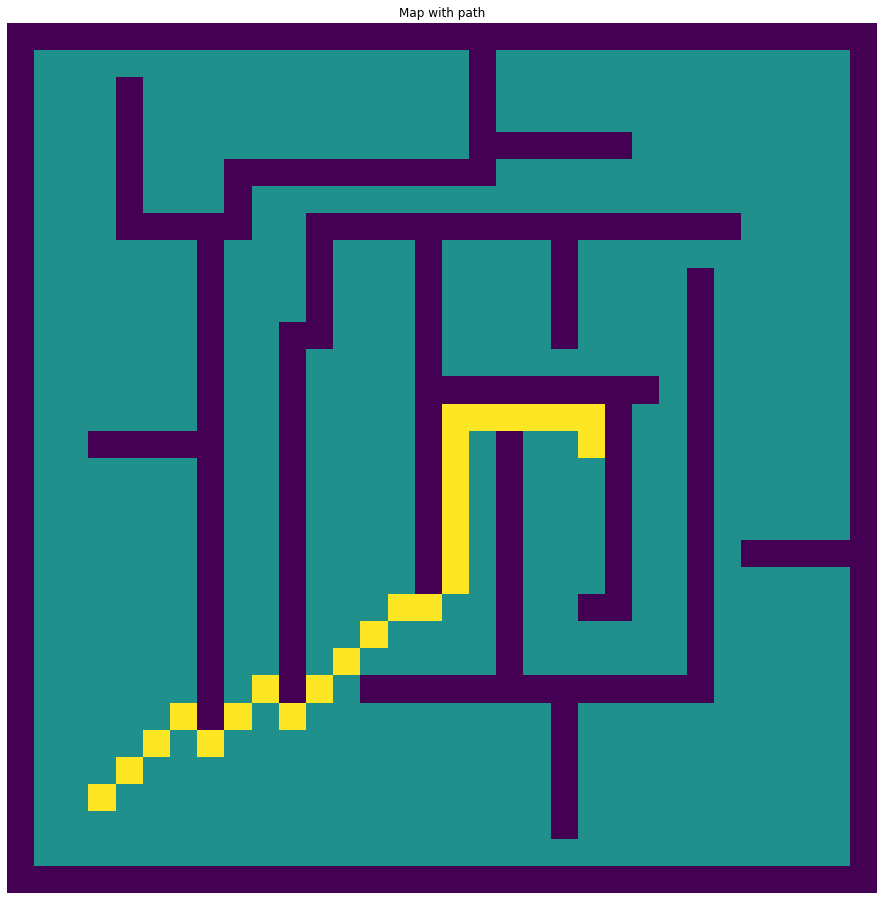

In [258]:
current_position = np.transpose(np.nonzero(cell_types == START))[0]
path = np.zeros(obstacle_map.shape)
prev_pos = np.zeros(current_position.shape)
prev_prev_pos = np.zeros(current_position.shape)
while True:
    x = current_position[0]
    y = current_position[1]
    state = int(states[x, y])
    if state == 0 or np.array_equal(current_position, prev_pos) or np.array_equal(current_position, prev_prev_pos):
        path[x, y] = 1
        break
    path[x, y] = 1
    prev_prev_pos = np.copy(prev_pos)
    prev_pos = np.copy(current_position)
    current_position = moves[policy[x, y]](x, y)
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with path')
ax.imshow(obstacle_map + path)